Importamos todas las librerias necesarias para nuestra solución

In [1]:
import numpy as np
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics, neighbors, tree, preprocessing
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from shutil import copyfile
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score 
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import math 
import category_encoders as ce
from sklearn import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import imblearn.combine as hib
from collections import Counter
import imblearn.combine as hib
import imblearn.over_sampling as os
import imblearn.under_sampling as us
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
from sklearn import feature_selection
import shap

## INTRODUCCIÓN AL PROBLEMA

Hemos escogido un problema de clasificación binario en el que tenemos que predecir si el salario anual de una persona de EEUU es mayor que 50 mil o no.<br>
El dataset lo hemos sacado de KEEL y lo elegimos porque cuenta con un gran número de ejemplos, atributos y tiene valores perdidos, lo que nos permite aplicar bastantes técnicas de las vistas en la asignatura.<br>
El enlace al problema es el siguiente: https://sci2s.ugr.es/keel/dataset.php?cod=192<br><br>
Lo primero que hicimos fue descargarnos el dataset que nos venía con formato '.dat'. Para que lo pudiesemos leer como en las prácticas le quitamos la cabecera y lo pasamos a formato csv

## LECTURA DE DATOS Y CREACION DE TRAIN Y TEST

Construimos las variables X e y, diciendole que ponga los valores perdidos a NaN, la columna a predecir se llama 'Class'

In [2]:
def leerDataset(nombreFichero,nombreVariablePredecir):
    datos = pd.read_csv(nombreFichero,na_values='?')
    y = datos[nombreVariablePredecir]
    y = ce.OrdinalEncoder().fit_transform(y)-1
    y = y.values.ravel()
    X = datos.drop(nombreVariablePredecir,axis=1)
    return X,y

In [3]:
X,y = leerDataset('adult.csv', 'Class')

Aplicamos hold-out para poder poner a prueba el razonamiento de nuestro algoritmo más adelante

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state = 12)

## IMPUTACION DE VALORES PERDIDOS Y PASO DE CATEGÓRICO A NOMINAL

Para pasar las variables de categorico a nominal hemos aplicado dos métodos distintos: el basado en la salida para aquellas variables que toman menos de seis valores y ordinal para los demás.<br> Esto lo hacemos porque el basado en la salida es mejor al tener en cuenta de que clase y categoría es el ejemplo, pero es más costoso que el ordinal, por lo que en caso de tener más valores posibles nos interesa un método más rápido.<br>
Además en la celda siguiente tambien vamos a imputar los valores perdidos por la moda en caso de las variables categóricas y por la media con la variables numéricas

In [5]:
nombres_variables_categoricas_menosDe6_valores = []
nombres_variables_categoricas_masDe6_valores = []
nombres_variables_numericas = X.select_dtypes(exclude="object").columns.values
nombres_variables_categoricas = X.select_dtypes(include="object").columns.values
for column in nombres_variables_categoricas:
    valores = len(pd.unique(X[column]))
    if (valores <=6 ):
        nombres_variables_categoricas_menosDe6_valores.append(column)
    if(valores >6 ):
        nombres_variables_categoricas_masDe6_valores.append(column)
categorical_menosDe6_imputer_transformer = pipeline.Pipeline([
    ("imputacion por la moda ", SimpleImputer(strategy='most_frequent')),
    ("Codificacion basada en salida ", ce.TargetEncoder(smoothing=0.0000001))]
)
categorical_masDe6_imputer_transformer = pipeline.Pipeline([
    ("imputacion por la moda ", SimpleImputer(strategy='most_frequent')),
    ("Codificacion basada en salida ", ce.OrdinalEncoder())]
)

preprocesamiento = ColumnTransformer(
    transformers=[
        ("media", SimpleImputer(strategy='mean') , nombres_variables_numericas),
        ("Categoricas menos de 6 valores",categorical_menosDe6_imputer_transformer,  nombres_variables_categoricas_menosDe6_valores),
        ("Categoricas mas de 6", categorical_masDe6_imputer_transformer, nombres_variables_categoricas_masDe6_valores)
    ]
)

## OUTLIERS

Vamos a hacer ahora un estudio de los outliers que están presentes en los datos 

In [6]:
from sklearn.base import TransformerMixin

class OutlierDetecion_treatment_IQR(TransformerMixin):
    def __init__(self, k=1.5):
        self.k=k
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.stats = X.describe().loc[['25%','50%','75%'],:]
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        Xaux = X.copy()
        IQRs = self.stats.loc['75%',:]-self.stats.loc['25%',:]
        limiteInf = self.stats.loc['25%',:]-self.k*IQRs
        limiteSup = self.stats.loc['75%',:]+self.k*IQRs
        menores = X<limiteInf
        mayores = X>limiteSup
        for c in Xaux.columns:
            indices = np.logical_or(menores[c], mayores[c]).tolist()
            if(np.any(indices)):
                indices = np.argwhere(indices).flatten()
                Xaux.loc[indices,c] = self.stats.loc['50%',c]
        return Xaux
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [7]:
class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    def __init__(self, k=2):
        self.k=k 
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.stats = X.describe().loc[['mean','std','50%'],:]
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        Xaux = X.copy()
        limiteInf = self.stats.loc['mean',:]-self.k*self.stats.loc['std',:]
        limiteSup = self.stats.loc['mean',:]+self.k*self.stats.loc['std',:]
        menores = X<limiteInf
        mayores = X>limiteSup
        for c in Xaux.columns:
            indices = np.logical_or(menores[c], mayores[c]).tolist()
            if(np.any(indices)):
                indices = np.argwhere(indices).flatten()
                Xaux.loc[indices,c] = self.stats.loc['50%',c]
        return Xaux
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Aplicamos lo anterior más una estandarización con media 0 y desviación estandar 1

In [8]:
pipe = pipeline.Pipeline([('pre procesamiento ', preprocesamiento),('estandarizacion', StandardScaler())])
X_train_imprimir_con_outliers = pipe.fit_transform(X_train,y_train);

Printeamos un histograma y un boxplot de cada variable antes de tratar los outliers

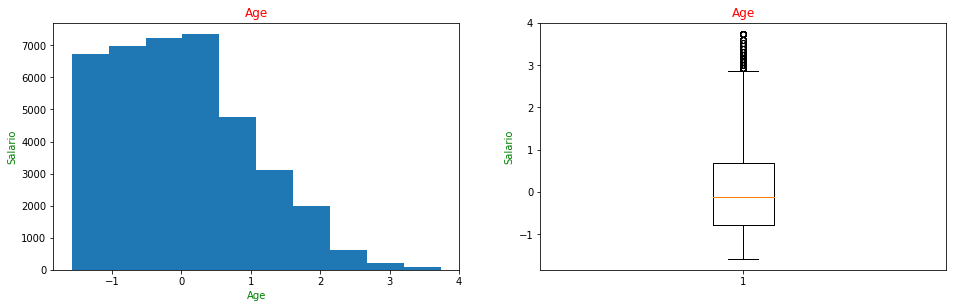

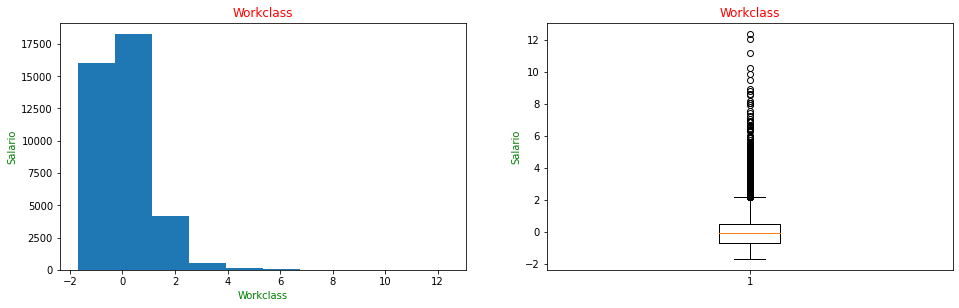

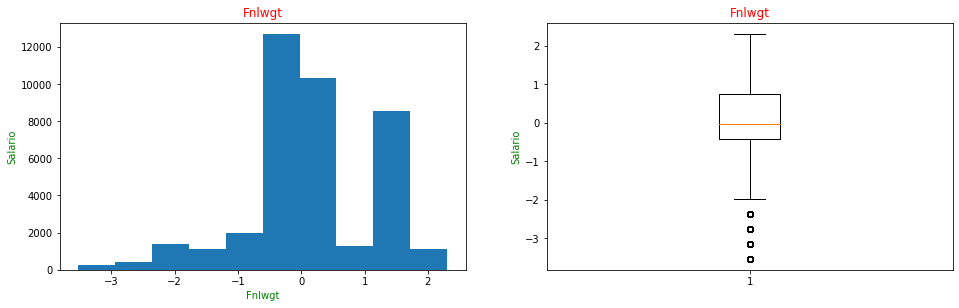

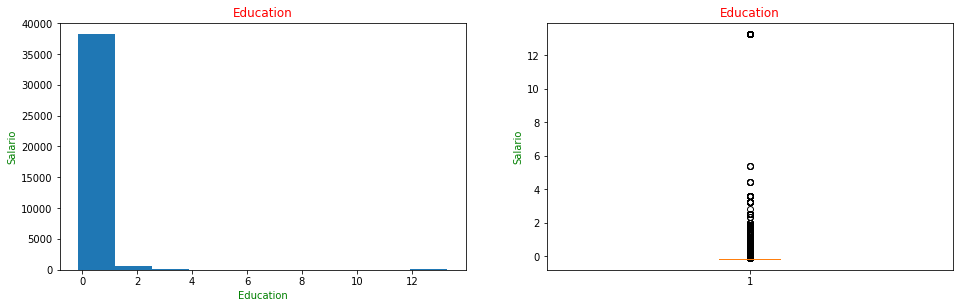

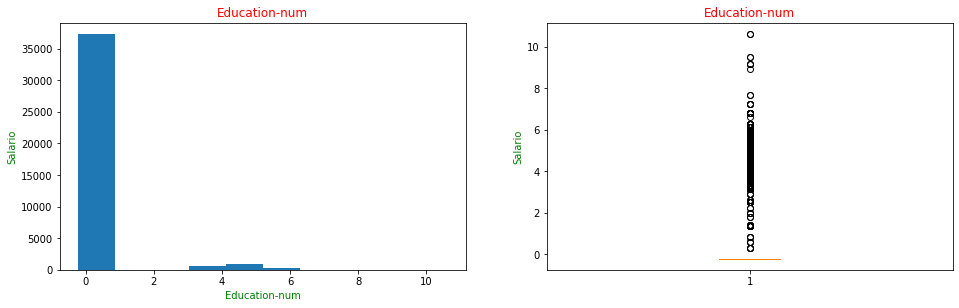

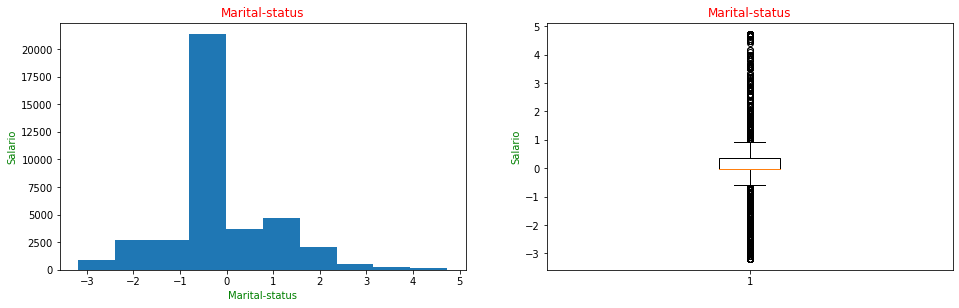

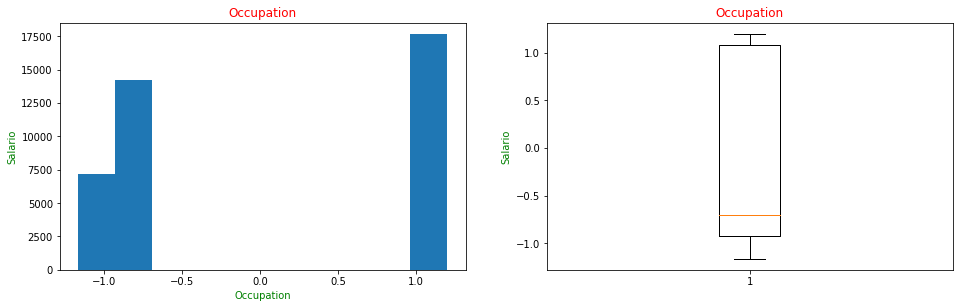

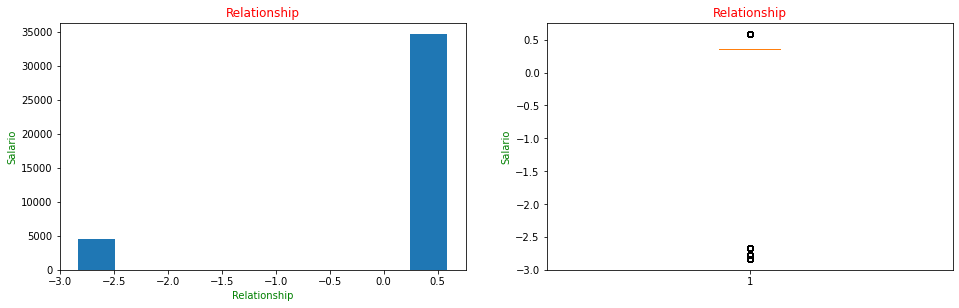

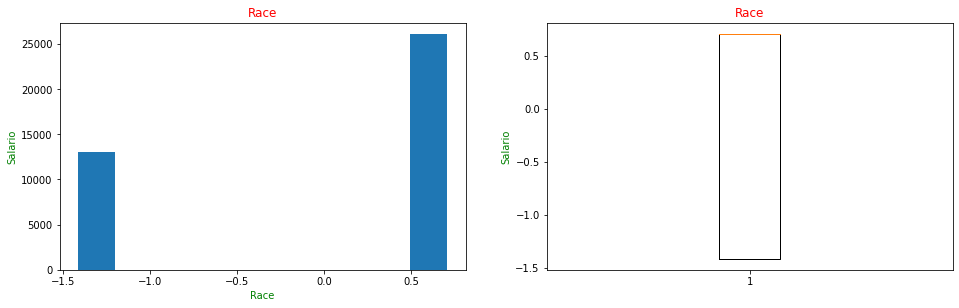

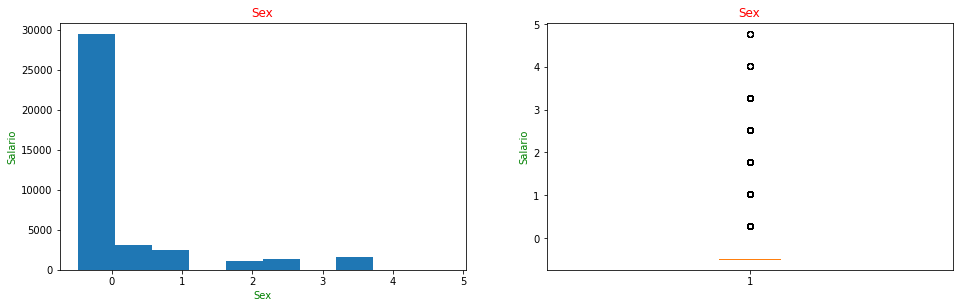

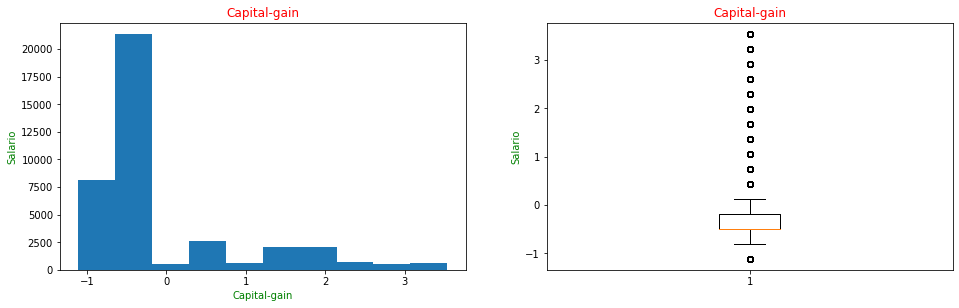

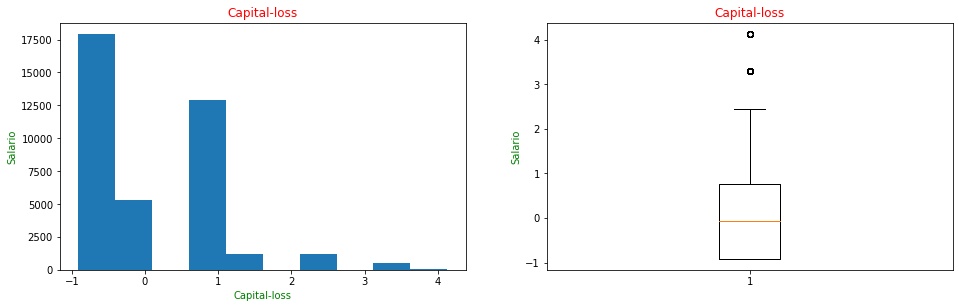

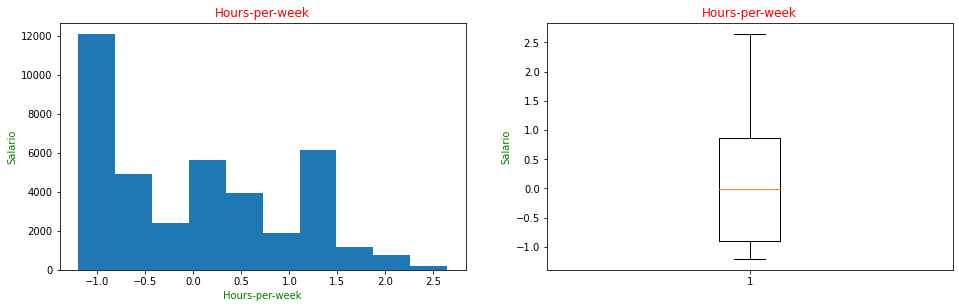

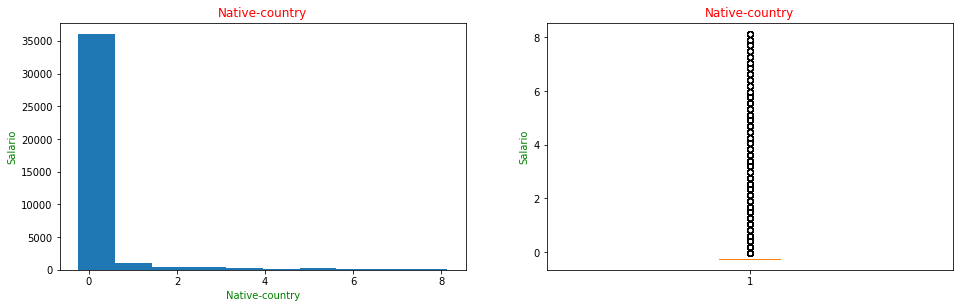

In [9]:
for i in range(X.shape[1]):
    nombreVariable = X.columns[i]
    plt.figure(figsize=(16,10))

    plt.subplot(221)
    plt.hist(X_train_imprimir_con_outliers[:,i])[1]
    plt.title(nombreVariable, c='r')
    plt.xlabel(nombreVariable, c = 'green')
    plt.ylabel("Salario", c = 'green')

    plt.subplot(222)
    plt.boxplot(X_train_imprimir_con_outliers[:,i])
    plt.title(nombreVariable,c='r')
    plt.ylabel("Salario", c = 'green')

In [10]:
pipe = pipeline.Pipeline([('pre procesamiento ', preprocesamiento),('quitarOutliers',OutlierDetecion_treatment_MeanStd(k=5)),('minMaxScaler', StandardScaler())])
X_train_imprimir_sin_outliers = pipe.fit_transform(X_train,y_train);
X_train_imprimir_sin_outliers = pd.DataFrame(X_train_imprimir_sin_outliers,columns=X_train.columns)

Printeamos un histograma y un boxplot de cada variable después de tratar los outliers

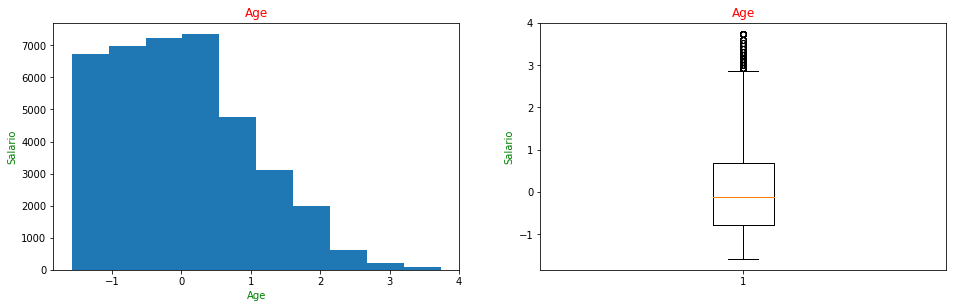

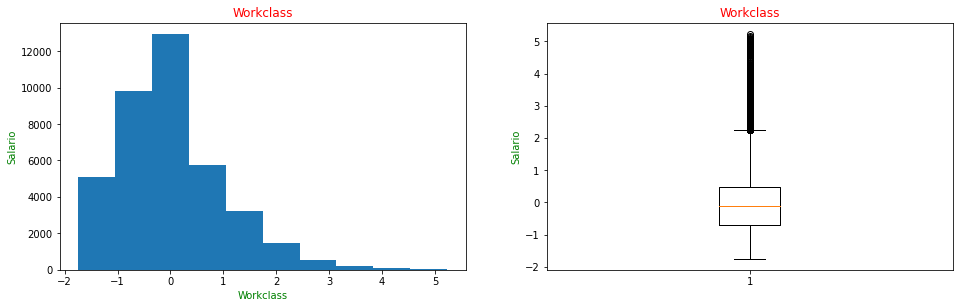

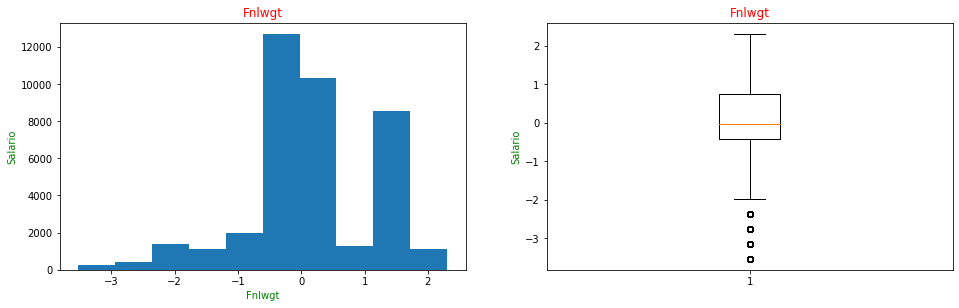

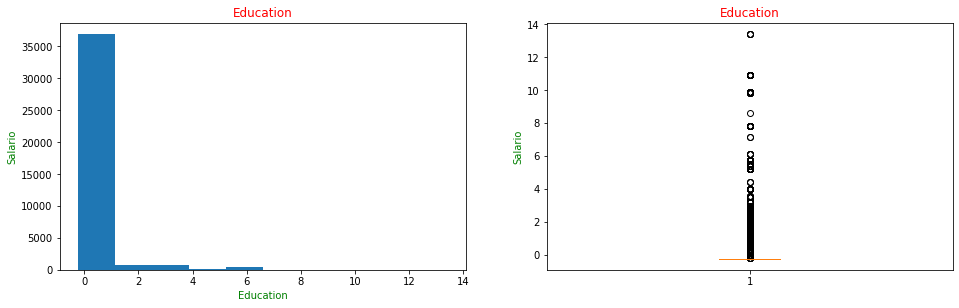

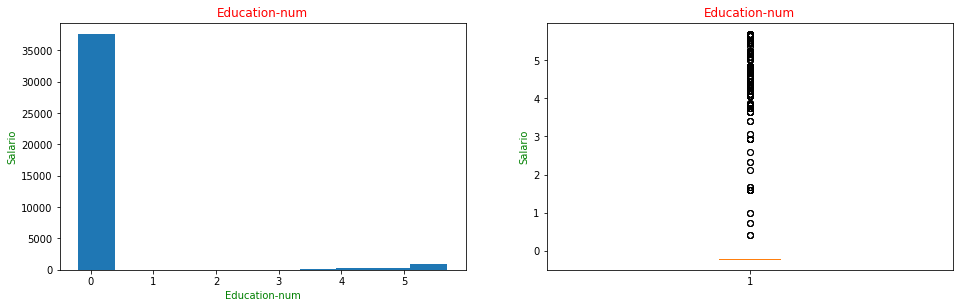

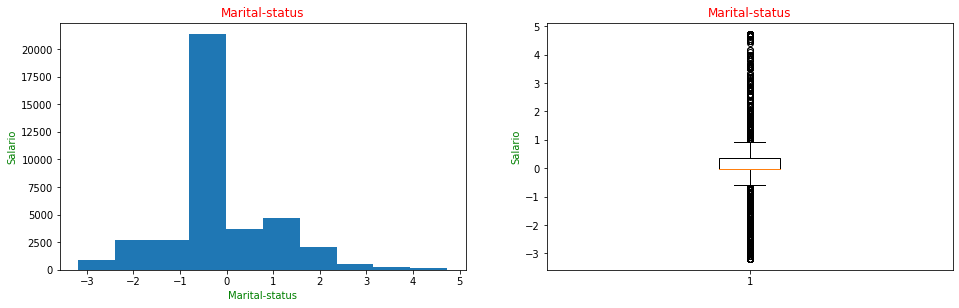

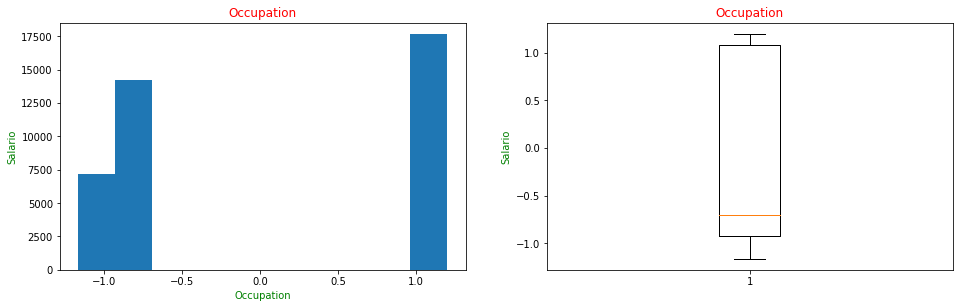

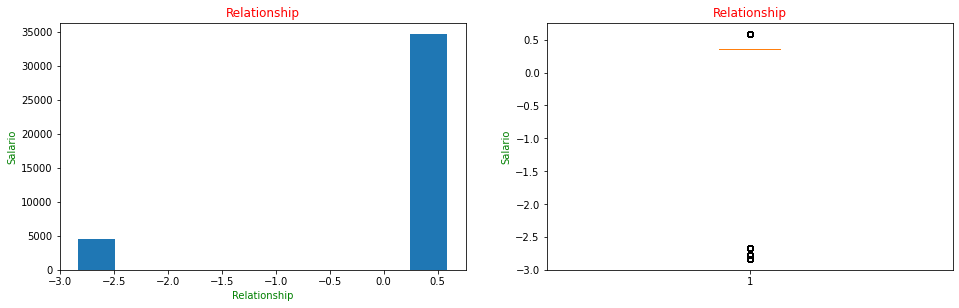

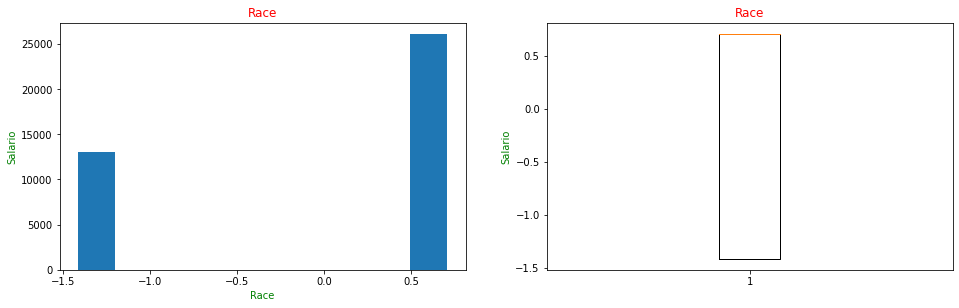

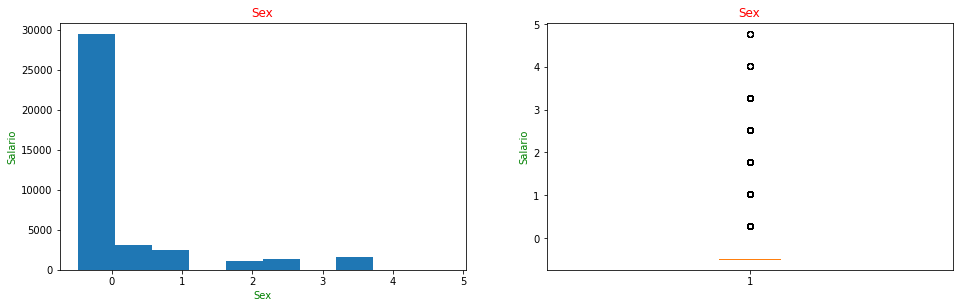

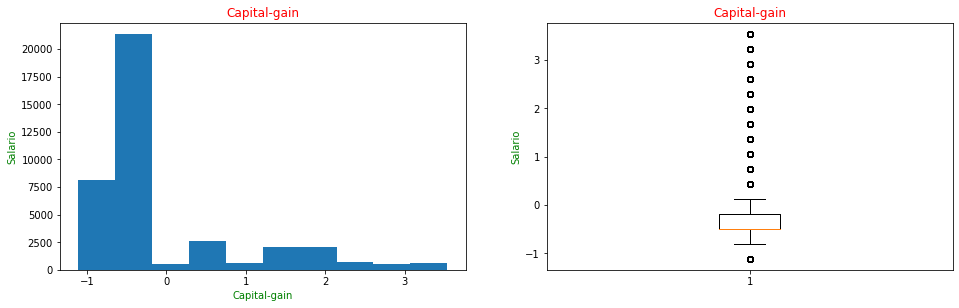

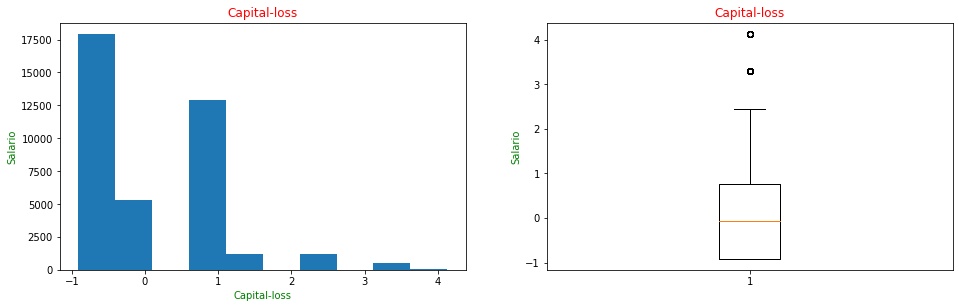

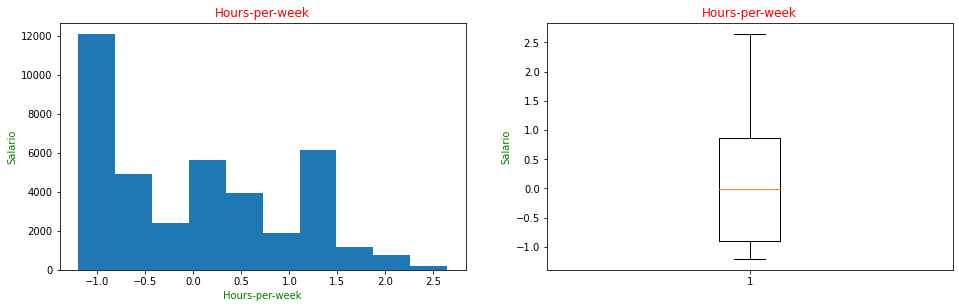

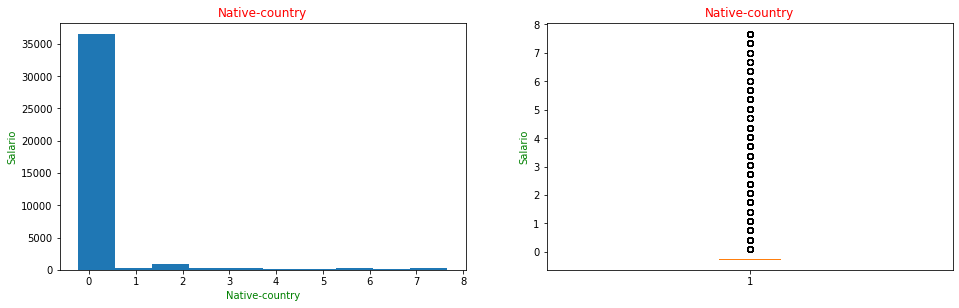

In [11]:
for i in range(X.shape[1]):
    nombreVariable = X.columns[i]
    plt.figure(figsize=(16,10))

    plt.subplot(221)
    plt.hist(X_train_imprimir_sin_outliers.iloc[:,i])[1]
    plt.title(nombreVariable, c='r')
    plt.xlabel(nombreVariable, c = 'green')
    plt.ylabel("Salario", c = 'green')

    plt.subplot(222)
    plt.boxplot(X_train_imprimir_sin_outliers.iloc[:,i])
    plt.title(nombreVariable,c='r')
    plt.ylabel("Salario", c = 'green')

## BUSCAMOS CORRELACIONES 

14 variables son igual demasiadas variables: veamos si tenemos algún tipo de correlación entre ellas

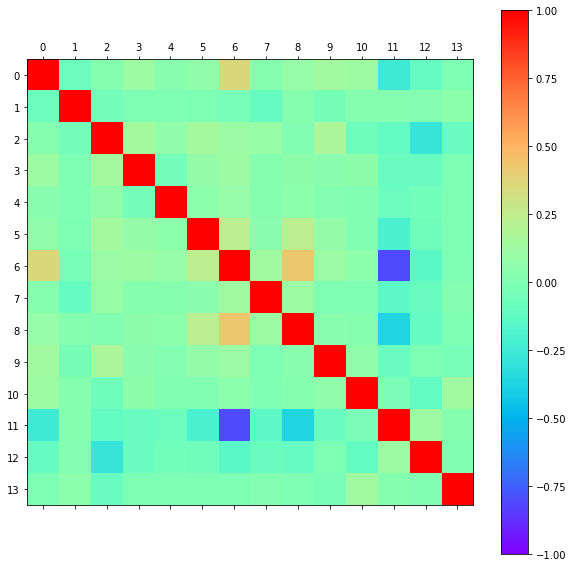

In [12]:
X_train = pd.DataFrame(X_train)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
correlaciones_sin_outliers  = X_train_imprimir_sin_outliers.corr()
cax = ax.matshow(correlaciones_sin_outliers, vmin=-1, vmax=1, cmap=plt.cm.rainbow)
fig.colorbar(cax)
ticks = np.arange(0,len(X_train.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks);

In [13]:
correlated_features = set()
for i in range(len(correlaciones_sin_outliers .columns)):
    for j in range(i):
        if abs(correlaciones_sin_outliers.iloc[i, j]) >= 0.8:
            colname = correlaciones_sin_outliers.columns[i]
            correlated_features.add(colname)
            print("Estan muy relacionadas las columnas {} y {}".format(X.columns[i],X.columns[j]))

Estan muy relacionadas las columnas Capital-loss y Occupation


## SELECTORES DE VARIABLES

Estas son algunas de las técnicas de selección de variables que hemos probado

In [14]:
# tecnicaSeleccion = feature_selection.RFE(LogisticRegression(solver='liblinear'),n_features_to_select=9,step=1)
# tecnicaSeleccion =  feature_selection.RFECV(LogisticRegression(solver='liblinear'),step = 1) # La que mejor funciona en regression logistica

# tecnicaSeleccion = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k = 9)
# tecnicaSeleccion = feature_selection.SelectPercentile(score_func=feature_selection.chi2, percentile = 0.95)
# tecnicaSeleccion = feature_selection.SelectPercentile(score_func=feature_selection.f_classif, percentile = 0.95)

Al final la que mejor nos ha funcionado ha sido esta

In [15]:
tecnicaSeleccion = feature_selection.SelectKBest(score_func=feature_selection.chi2, k = 9)

## TODO JUNTO

Aplicamos todo lo anterior a train y test. Solamente entrenamos la pipeline con los ejemplos de entrenamiento ya que sino estaríamos haciendo trampa

In [16]:
pipe = pipeline.Pipeline([('pre procesamiento ', preprocesamiento),('seleccion variables', tecnicaSeleccion)])
pipe.fit(X_train, y_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

cols = tecnicaSeleccion.get_support(indices=True)
columnasOriginales = X.columns[cols]

# pipe2 = pipeline.Pipeline([('quitarOutliers',OutlierDetecion_treatment_IQR(k=5)),('estandarizacion', StandardScaler())])
pipe = pipeline.Pipeline([('quitarOutliers',OutlierDetecion_treatment_MeanStd(k=5)),('estandarizacion', StandardScaler())])
pipe.fit(X_train, y_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

## PCA

Vemos en caso de aplicar PCA el % de información que mantendríamos al quedarnos con n variables

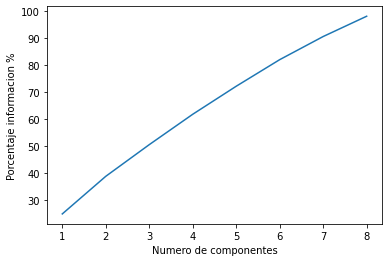

In [17]:
listaAccTrain = [] # lista para almancenar el rendimiento de las diferentes posibilidades en train
listaAccTest = [] # lista para almancenar el rendimiento de las diferentes posibilidades en test
listaPorInf = [] # lista para almancenar el porcentje de información representado por las diferentes posibilidades
cantidadVariables = X_train.shape[1]

for numeroComponentes in range(1,cantidadVariables):
    pipe = pipeline.Pipeline([('estandarizacion', StandardScaler()),('pca', PCA(n_components=numeroComponentes, svd_solver='full')),( 'Regresion logistica', LogisticRegression())])
    pipe.fit(X_train,y_train)
    prediccionTrain = pipe.predict(X_train)
    prediccionTest = pipe.predict(X_test)
    accTrain = metrics.accuracy_score(y_train,prediccionTrain)*100
    accTest =  metrics.accuracy_score(y_test,prediccionTest)*100
    listaAccTrain.append(accTrain)
    listaAccTest.append(accTest)
    listaPorInf.append(sum(pipe['pca'].explained_variance_ratio_)*100)
plt.figure()
plt.plot(range(1,cantidadVariables),listaPorInf)
plt.xlabel("Numero de componentes")
plt.ylabel("Porcentaje informacion %");

Nos quedamos con el 95% de la información

In [18]:
print("_______________ANTES DE PCA_______________")
print("Tamaño dataset train : {} ".format(X_train.shape))
print("Tamaño dataset test : {} ".format(X_test.shape))

pcaPrincipal = PCA(n_components=0.95, svd_solver='full')

pcaPrincipal.fit(X_train)

X_train_pca = pcaPrincipal.transform(X_train)
X_test_pca = pcaPrincipal.transform(X_test)
print("\n_______________DESPUES DE PCA_______________")
print("Tamaño dataset train : {} ".format(X_train_pca.shape))
print("Tamaño dataset test : {} ".format(X_test_pca.shape))

_______________ANTES DE PCA_______________
Tamaño dataset train : (39073, 9) 
Tamaño dataset test : (9769, 9) 

_______________DESPUES DE PCA_______________
Tamaño dataset train : (39073, 8) 
Tamaño dataset test : (9769, 8) 


Aqui podremos ver la cantidad de informacion que aporta cada una de las variables, la conclusion sacada es que nos hemos quedado con el minimo numero de variables necesarias para no tener informacion redundante.

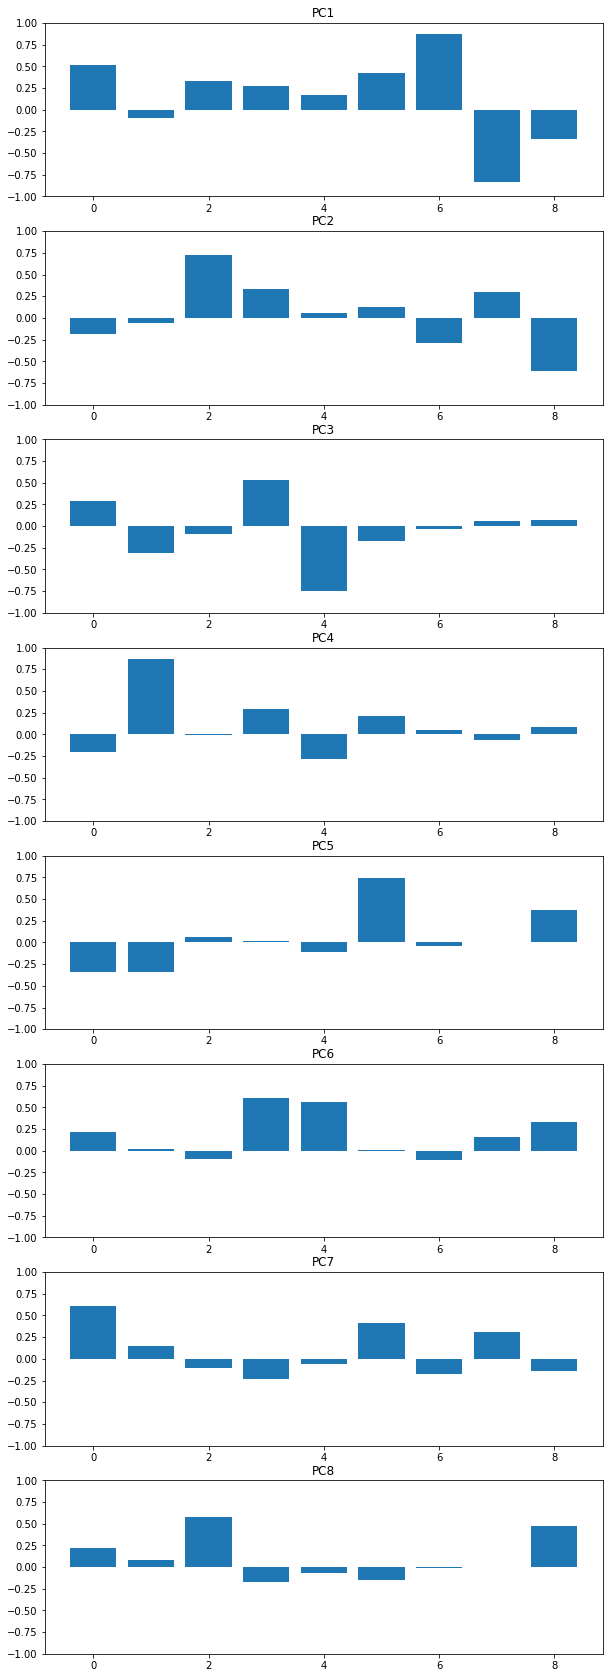

In [19]:
variablesConPCs =  np.vstack((X_train.T, X_train_pca.T))
correlacionesPCs = np.corrcoef(variablesConPCs)
corrPCsVars = correlacionesPCs[-pcaPrincipal.n_components_ :,:X_train.shape[1]]

fig = plt.figure(1, figsize=(10,30))
for i in range(corrPCsVars.shape[0]):
    fig.add_subplot(corrPCsVars.shape[0],1,i+1)
    plt.title("PC"+str(i+1))
    plt.ylim([-1,1])
    plt.bar(range(corrPCsVars.shape[1]),corrPCsVars[i,:])
plt.show()

In [20]:
X_train = X_train_pca
X_test = X_test_pca

## SELECCION DE INSTANCIAS

Tenemos demasiados ejemplos: vamos a intentar paliar este problema

In [21]:
def mostrar(clasificador, X, y, Xtst, ytst, method=None, Xsel=None, ysel=None):
    h = .02
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    x_min, x_max = X[:, 0].min() * 0.9, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 0.9, X[:, 1].max() * 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clasificador.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(17,5.5))

    if Xsel is not None:
        plt.subplot(131)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
        plt.scatter(Xsel[:, 0], Xsel[:, 1], c=ysel, cmap=cmap_bold, facecolor='none')
        plt.title("Ejemplos seleccionados con %s" % (method))
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.subplot(132)
    else:
        plt.subplot(121)

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.title("Ejemplos de Train")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    if Xsel is not None:
        plt.subplot(133)
    else:
        plt.subplot(122)

    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    plt.scatter(Xtst[:, 0], Xtst[:, 1], c=ytst, cmap=cmap_bold)
    plt.title("Ejemplos de Test")
    # plt.xlim(xx.min(), xx.max())
    # plt.ylim(yy.min(), yy.max())

    if type(clasificador) == neighbors.KNeighborsClassifier:
        plt.suptitle('Clasificador: %iNN' % (clasificador.n_neighbors), fontsize=16)
    else:
        plt.suptitle('Clasificador: Decision Tree', fontsize=16)

    plt.show()
    return

In [22]:
def leaveOneOut(clasificador, X, y):
    if type(clasificador) != neighbors.KNeighborsClassifier:
        prediction = clasificador.predict(X)
        return prediction
    distancias, vecinos = clasificador.kneighbors(X, n_neighbors=clasificador.n_neighbors + 1, return_distance=True)
    vecinosClase = clasificador._y[vecinos]
    mascara = (distancias[:,0] == 0)
    vecinosClase[mascara,0] =  vecinosClase[mascara,-1]
    prediction = stats.mode(vecinosClase[:,:clasificador.n_neighbors],axis=1)

    return prediction.mode

In [23]:
def ENN(X, y, k=3):
    S = np.ones(X.shape[0],dtype = bool)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    for i in range(0, X.shape[0]):
        S[i] = False
        knn.fit(X[S],y[S])
        salidas = knn.predict(X)
        if(salidas[i] == y[i]):
            S[i] = True
    return S

In [24]:
def CNN(X, y, k=1):
    np.random.seed(12312)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    S = np.zeros((X.shape[0]),dtype=bool)
    nClases = np.unique(y)
    for c in nClases:
        indicesClase = np.where(y == c)[0]  
        instanciaAleatoria = indicesClase[np.random.randint(len(indicesClase))]
        S[instanciaAleatoria] = True
    notS = 1-S
    knn = knn.fit(X[S],y[S])
    fallados = -1
    while fallados != 0:
        fallados = 0
        indices = np.where(notS)[0]
        for i in np.random.permutation(indices):
            prediccion = knn.predict(X[i].reshape(1,-1))
            if(prediccion != y[i]):
                S[i] = True
                knn.fit(X[S],y[S])
                fallados += 1
        notS = 1-S
        print("CNN, fin de iteración, fallados: {}, ejemplos en S: {}".format(fallados, np.sum(S)))

    return S

In [25]:
def RMHC(X, y, s=0.1, iteraciones=1000, k=1):
    np.random.seed(12312)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    nSel = int(s * X.shape[0])
    permute = np.random.permutation(np.arange(X.shape[0]))
    seleccionadas = permute[:nSel]
    noSeleccionadas = permute[nSel:]
    knn.fit(X[seleccionadas],y[seleccionadas])
    salidas = leaveOneOut(knn,X,y)
    acc = metrics.accuracy_score(y,salidas)
    for i in range(0, iteraciones):
        quitar = np.random.randint(len(seleccionadas))
        poner = np.random.randint(len(noSeleccionadas))
        aux = seleccionadas[quitar]
        seleccionadas[quitar] = noSeleccionadas[poner]
        knn = knn.fit(X[seleccionadas],y[seleccionadas])
        salidas = leaveOneOut(knn,X,y)
        accNew = metrics.accuracy_score(y,salidas)
        if(acc>accNew):
                seleccionadas[quitar] = aux
        else:
                acc = accNew
                noSeleccionadas[poner] = aux
        if i % 100 == 0:
                print("precision en iteracion {}: {}".format(i, acc))
    S = np.array([ejemplo in seleccionadas for ejemplo in np.arange(X.shape[0])])

    return S

Probamos con varios metodos de selección de instancias y nos quedamos con el que mejor nos va en relación con el coste que nos supone calcularlo<br>
Al ser todos bastante lentos nos guardamos la mascara de booleanos de todos

In [26]:
#tarda 10 minutos en ejecutar => nos guardamos la máscara de booleanos
# S = CNN(X_train,y_train)
# np.savetxt('ejemplosCNN.txt',S)

In [27]:
#estuvo 962 minutos y no teminó
# S = ENN(X_train,y_train)
# np.savetxt('ejemplosENN.txt',S)

In [28]:
#este tarda unos 10 min y es el que mejor va con diferencia
# S = RMHC(X_train,y_train)
# np.savetxt('ejemplosRMHC.txt',S)

Cargamos la seleccion previamente hecha

In [29]:
# S = np.loadtxt('ejemplosCNN.txt').astype(bool)
# S = np.loadtxt('ejemplosENN.txt').astype(bool)
S = np.loadtxt('ejemplosRMHC.txt').astype(bool)

Decidimos quedarnos con RMHC

In [30]:
reduction = (X_train.shape[0]-np.sum(S))*100/X_train.shape[0]
print("Obtenemos una reduccion del {:.2f}% sin perjudicar mucho el acierto en test".format(reduction))

Obtenemos una reduccion del 90.00% sin perjudicar mucho el acierto en test


Vemos como nos afecta la selección de instancias con knn por ejemplo

In [31]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

precisionTrain = metrics.accuracy_score(y_train,knn.predict(X_train))*100
precisionTest = metrics.accuracy_score(y_test,knn.predict(X_test))*100

print("La precision en train es de {}%".format(precisionTrain))
print("La precision en test es de {}%".format(precisionTest))

La precision en train es de 88.01218232539092%
La precision en test es de 83.44764049544477%


ANTES:


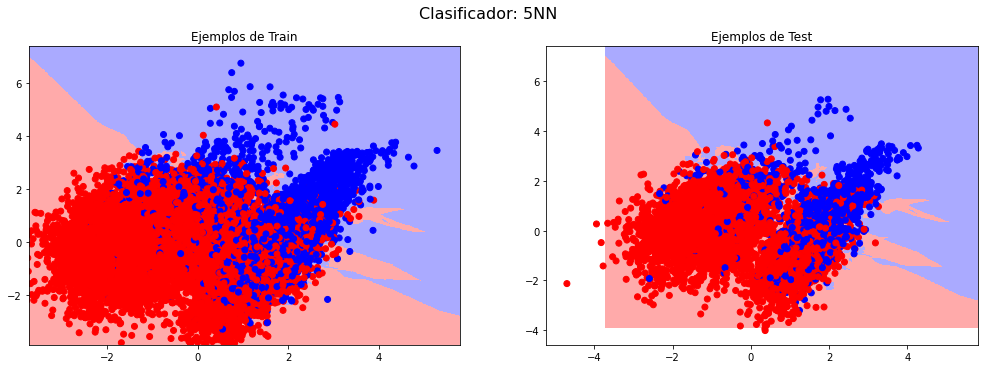

In [32]:
print('ANTES:')
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X_train)
X_train2D = pca.transform(X_train)
X_test2D = pca.transform(X_test)
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train2D, y_train)
mostrar(knn, X_train2D, y_train, X_test2D, y_test, method=None, Xsel=None, ysel=None)

In [33]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train[S], y_train[S])

predictionTrain = leaveOneOut(knn,X_train,y_train)
precisionTrain = metrics.accuracy_score(y_train,predictionTrain)*100
precisionTest = metrics.accuracy_score(y_test,knn.predict(X_test))*100

print("La precision en train es de {}%".format(precisionTrain))
print("La precision en test es de {}%".format(precisionTest))

X_train = X_train[S]
y_train = y_train[S]

La precision en train es de 83.1699639137%
La precision en test es de 83.48858634455932%


Conseguimos no solo quitarnos muchos ejemplos sino además mejorar levemente el porcentaje en test

DESPUES:


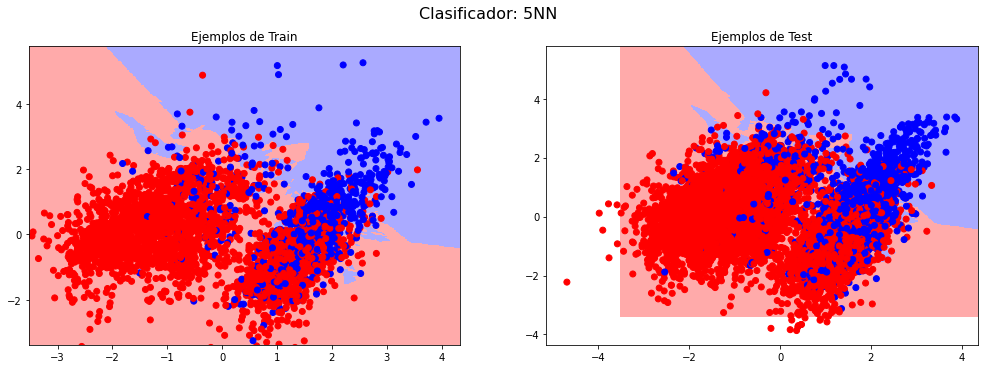

In [34]:
print('DESPUES:')
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X_train)
X_train2D = pca.transform(X_train)
X_test2D = pca.transform(X_test)
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train2D, y_train)
mostrar(knn, X_train2D, y_train, X_test2D, y_test, method=None, Xsel=None, ysel=None)

Hemos tenido cuidado una vez más en aplicarle la selección solo al train, el test no lo hemos manipulado

## PROBLEMA DE DESBALANCEO

In [35]:
nPersonasPorDebajoUmbral = y_train[y_train == 0].shape[0]
nPersonasPorEncimaUmbral = y_train[y_train == 1].shape[0]
print('Tenemos {} ejemplos con salario por debajo del umbral y {} por encima => es una problema desbalanceado.'.format(nPersonasPorDebajoUmbral,nPersonasPorEncimaUmbral))

Tenemos 3032 ejemplos con salario por debajo del umbral y 875 por encima => es una problema desbalanceado.


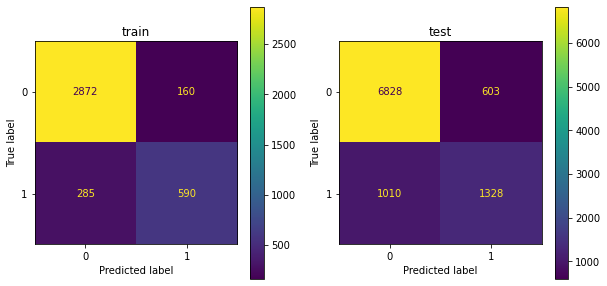

In [36]:
modeloAntes = knn.fit(X_train, y_train)
fig, axs = plt.subplots(1, 2,figsize=(10,5))
plot_confusion_matrix(knn, X_train, y_train,ax = axs[0])
axs[0].set_title("train")
plot_confusion_matrix(knn, X_test, y_test,ax = axs[1])
axs[1].set_title("test");

Tenemos un buen porcentaje de acierto pero se debe a que al ser casi todos clase 0 en caso de duda predecimos clase 0, fallando un porcentaje considerable de la clase 1

Como podemos ver en esta tabla, aunque ya lo sospechabamos con la matriz de confusion, tenemos malas estadísticas a la hora de predecir la clase 1 => tenemos que hacer algo para solucionar esto

In [37]:
reportAntes = classification_report(y_test, knn.predict(X_test))
print(reportAntes)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      7431
           1       0.69      0.57      0.62      2338

    accuracy                           0.83      9769
   macro avg       0.78      0.74      0.76      9769
weighted avg       0.83      0.83      0.83      9769



In [38]:
prediccionesTest = knn.predict(X_test)
mediaGeometricaAntes = geometric_mean_score(y_test,prediccionesTest)*100
print('La media geometrica actualmente es del {}%'.format(round(mediaGeometricaAntes,2)))

La media geometrica actualmente es del 72.24%


In [39]:
np.random.seed(42)
listaMetodos = ['RUS','Tomek Links','CNN','OSS','NCL','ROS','SMOTE','SMOTE con Tomek Links','SMOTE con ENN']
listaTecnicas = [us.RandomUnderSampler(random_state=42),us.TomekLinks(),us.CondensedNearestNeighbour(random_state=42),us.OneSidedSelection(random_state=42),us.NeighbourhoodCleaningRule(),os.RandomOverSampler(random_state=42),os.SMOTE(random_state=42),hib.SMOTETomek(random_state=42),hib.SMOTEENN(random_state=42)]

listaGM = []
for nombre, metodo in zip(listaMetodos, listaTecnicas):
    pipe = Pipeline([('resampler',metodo),('knn',neighbors.KNeighborsClassifier())])
    pipe = pipe.fit(X_train,y_train)
    prediccionesTrain = pipe.predict(X_train)
    gmTrain = geometric_mean_score(y_train,prediccionesTrain)
    print('La media geometrica con {} en train es {}'.format(nombre,gmTrain))
    prediccionesTest = pipe.predict(X_test)
    gmTest = geometric_mean_score(y_test,prediccionesTest)
    listaGM.append(gmTest)
    print('La media geometrica con {} en test es {}'.format(nombre,gmTest))

La media geometrica con RUS en train es 0.8266941964134722
La media geometrica con RUS en test es 0.7940310959851137
La media geometrica con Tomek Links en train es 0.8213991538349942
La media geometrica con Tomek Links en test es 0.750124742523468
La media geometrica con CNN en train es 0.8129701516017679
La media geometrica con CNN en test es 0.7674326289894579
La media geometrica con OSS en train es 0.8213991538349942
La media geometrica con OSS en test es 0.750124742523468
La media geometrica con NCL en train es 0.8472324738119359
La media geometrica con NCL en test es 0.8005724315768623
La media geometrica con ROS en train es 0.8804626478052169
La media geometrica con ROS en test es 0.7722504309992775
La media geometrica con SMOTE en train es 0.8932059175560698
La media geometrica con SMOTE en test es 0.7764394282970151
La media geometrica con SMOTE con Tomek Links en train es 0.8908810548559465
La media geometrica con SMOTE con Tomek Links en test es 0.7766471159609546
La media g

In [40]:
mejorMetodo = listaMetodos[np.argmax(listaGM)]
mediaGeometricaDespues = np.max(listaGM)*100
print('Conseguimos subir la media geometrica del {:.2f}% al {:.2f}% con {}'.format(mediaGeometricaAntes,mediaGeometricaDespues,mejorMetodo))

Conseguimos subir la media geometrica del 72.24% al 80.06% con NCL


ANTES DE APLICAR NCL:


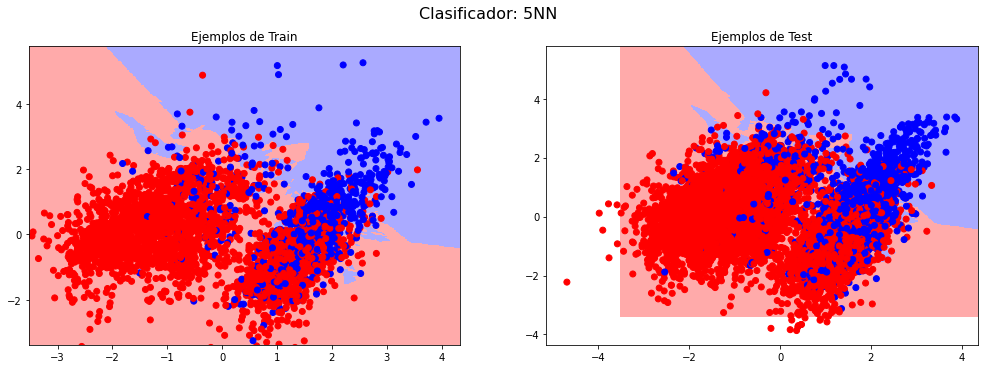

DESPUES DE APLICAR NCL:


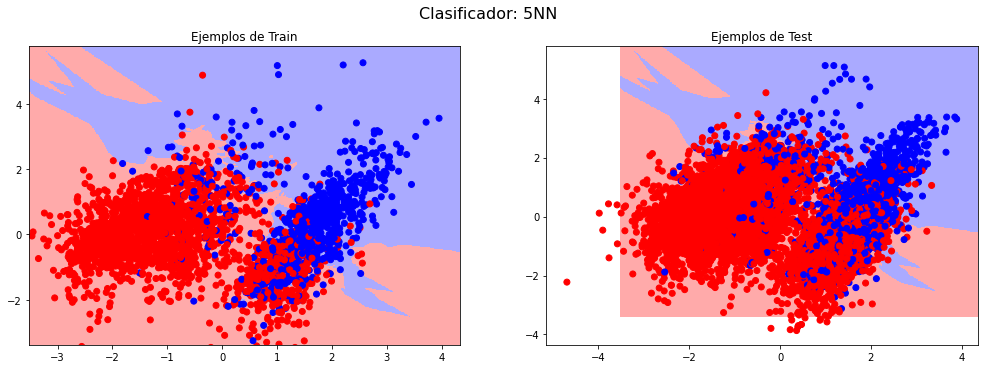

In [41]:
resampler = listaTecnicas[np.argmax(listaGM)]
X_sampled, y_sampled = resampler.fit_resample(X_train,y_train)

print('ANTES DE APLICAR NCL:')
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X_train)
X_train_2D = pca.transform(X_train)
X_test_2D = pca.transform(X_test)
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train_2D, y_train)
mostrar(knn, X_train_2D, y_train, X_test_2D, y_test, method=None, Xsel=None, ysel=None)

print('DESPUES DE APLICAR NCL:')
X_sampled_2D = pca.transform(X_sampled)
X_test_2D = pca.transform(X_test)
knn = neighbors.KNeighborsClassifier()
knn.fit(X_sampled_2D, y_sampled)
mostrar(knn, X_sampled_2D, y_sampled, X_test_2D, y_test, method=None, Xsel=None, ysel=None)

In [42]:
print('NCL es un método de under-sampling')
print('ANTES DE APLICAR NCL:')
print('\t{} ejemplos en total'.format(y_train.shape[0]))
clase0Antes = y_train[y_train == 0].shape[0]
clase1Antes = y_train[y_train == 1].shape[0]
print('\t{} ejemplos de la clase 0'.format(clase0Antes))
print('\t{} ejemplos de la clase 1'.format(clase1Antes))

print('DESPUES DE APLICAR NCL:')
print('\t{} ejemplos en total'.format(y_sampled.shape[0]))
clase0Despues = y_sampled[y_sampled == 0].shape[0]
clase1Despues = y_sampled[y_sampled == 1].shape[0]
print('\t{} ejemplos de la clase 0'.format(clase0Despues))
print('\t{} ejemplos de la clase 1'.format(clase1Despues))
ejemplosQuitados = clase0Antes-clase0Despues
reduccion = ejemplosQuitados*100/clase0Antes
print('\n\n Nos hemos quitado {} ejemplos de la clase 0: el {:.2f}%'.format(ejemplosQuitados,reduccion))

NCL es un método de under-sampling
ANTES DE APLICAR NCL:
	3907 ejemplos en total
	3032 ejemplos de la clase 0
	875 ejemplos de la clase 1
DESPUES DE APLICAR NCL:
	3097 ejemplos en total
	2222 ejemplos de la clase 0
	875 ejemplos de la clase 1


 Nos hemos quitado 810 ejemplos de la clase 0: el 26.72%


Perdemos en accuracy, pero ganamos en generalizacion

In [43]:
knn.fit(X_sampled,y_sampled)
precisionTrain = metrics.accuracy_score(y_train,knn.predict(X_train))*100
precisionTest = metrics.accuracy_score(y_test,knn.predict(X_test))*100
print("La precision en train es de {}%".format(precisionTrain))
print("La precision en test es de {}%".format(precisionTest))

La precision en train es de 83.6447402098797%
La precision en test es de 80.64284983109837%


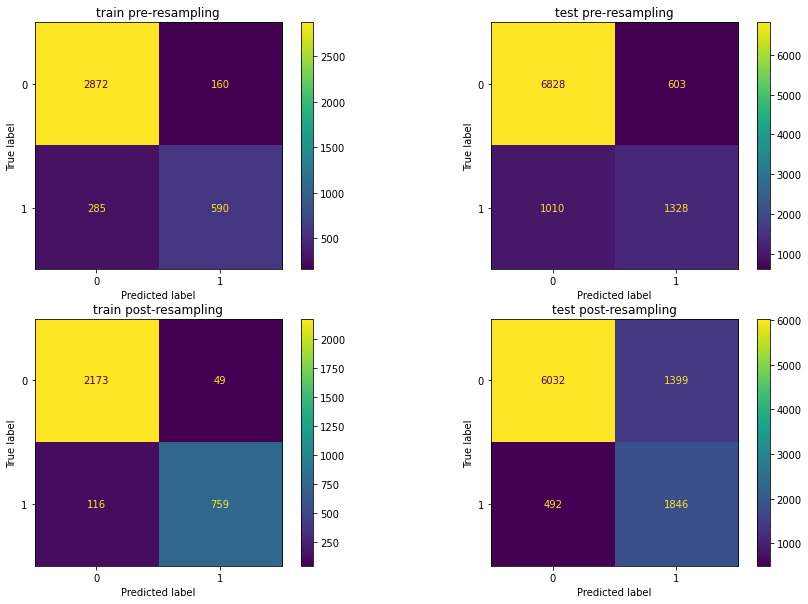

In [44]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
plot_confusion_matrix(modeloAntes, X_train, y_train,ax = axs[0, 0])
axs[0, 0].set_title("train pre-resampling")
plot_confusion_matrix(modeloAntes, X_test, y_test,ax = axs[0, 1])
axs[0, 1].set_title("test pre-resampling")
plot_confusion_matrix(knn, X_sampled, y_sampled,ax = axs[1, 0])
axs[1, 0].set_title("train post-resampling")
plot_confusion_matrix(knn, X_test, y_test,ax = axs[1, 1])
axs[1, 1].set_title("test post-resampling");

Perdemos precision en la clase uno porque fallamos más ejemplos que son de la clase 0, pero ganamos en recall porque predecimos bien más ejemplos de la clase 1. 
Esto nos hace perder accuracy porque la clase 0 es gran parte del dataset, pero ganamos en generalización

In [45]:
reportDespues = classification_report(y_test, knn.predict(X_test))
print('ANTES DEL RESAMPLING:')
print(reportAntes)
print('DESPUES DEL RESAMPLING:')
print(reportDespues)

ANTES DEL RESAMPLING:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      7431
           1       0.69      0.57      0.62      2338

    accuracy                           0.83      9769
   macro avg       0.78      0.74      0.76      9769
weighted avg       0.83      0.83      0.83      9769

DESPUES DEL RESAMPLING:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      7431
           1       0.57      0.79      0.66      2338

    accuracy                           0.81      9769
   macro avg       0.75      0.80      0.76      9769
weighted avg       0.84      0.81      0.82      9769



In [46]:
np.random.seed(12)
parameters = {'n_neighbors': [5, 7, 9, 10], 'weights': ['uniform', 'distance'], 'p': [1, 2, 1.5, 3],'algorithm':['ball_tree', 'kd_tree', 'brute']}
cv = model_selection.StratifiedKFold(n_splits=10)
gridsearch =  model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid = parameters, cv=cv, n_jobs=-1,scoring='roc_auc')
gridsearch.fit(X_sampled,y_sampled)
mejorModelo = gridsearch.best_estimator_

In [47]:
prediccionTrain = mejorModelo.predict(X_sampled)
gmTrain = geometric_mean_score(y_sampled,prediccionTrain)*100
prediccionTest = mejorModelo.predict(X_test)
gmTest = geometric_mean_score(y_test,prediccionTest)*100
print('La media geometrica en train es: {}%'.format(round(gmTrain,2)))
print('La media geometrica en test es: {}%'.format(round(gmTest,2)))
accTrain = mejorModelo.score(X_sampled,y_sampled)*100
accTest = mejorModelo.score(X_test,y_test)*100
print("La precision en train es de {}%".format(accTrain))
print("La precision en test es de {}%".format(accTest))

La media geometrica en train es: 100.0%
La media geometrica en test es: 80.4%
La precision en train es de 100.0%
La precision en test es de 80.9601801617361%


## IMPORTANCIA DE LAS VARIABLES

In [57]:
shap.initjs()

#Devolvemos tanto el train como el test a su base original
X_test_base_original = pcaPrincipal.inverse_transform(X_test)
X_test_base_original = pd.DataFrame(X_test_base_original,columns=columnasOriginales)
X_train_base_original = pcaPrincipal.inverse_transform(X_sampled)
X_train_base_original = pd.DataFrame(X_train_base_original,columns=columnasOriginales)

#hacemos un clustering del train para que vaya más rápido shap
X_train_base_original_resumen = shap.kmeans(X_train_base_original, 50)

mejorModelo.fit(X_train_base_original,y_sampled)

explainer = shap.KernelExplainer(mejorModelo.predict_proba, X_train_base_original_resumen)
shap_values = explainer.shap_values(X_test_base_original.iloc[0,:])

In [61]:
print('Importacia de las variables para los ejemplos de personas con 50 mil de salario anual o menos')
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_base_original.iloc[0,:])

Importacia de las variables para los ejemplos de personas con 50 mil de salario anual o menos


In [62]:
print('Importacia de las variables para los ejemplos de personas con más de 50 mil de salario anual')
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_base_original.iloc[0,:])

Importacia de las variables para los ejemplos de personas con más de 50 mil de salario anual


Se puede apreciar facilmente que el trabajo, la edad, el estado civil y los gastos son variables muy importantes para predecir aquellas personas que están tanto por encima de 50 mil de salario anual como por debajo

## PRUEBA CON ARBOL DE DECISION

In [ ]:
listaAccTrain = []
listaAccTest = []
# Para cada tipo de árbol (CART y C4.5)
for tipoArbol in ['gini','entropy']:
    print("\nTipo de arbol : {}".format(tipoArbol))
    # LLamada al constructor del árbol de decisión
    clasificador = tree.DecisionTreeClassifier(criterion=tipoArbol)
    clasificador.fit(X_train, y_train) 
    precisionTrain = metrics.accuracy_score(y_train,clasificador.predict(X_train))*100
    precisionTest = metrics.accuracy_score(y_test,clasificador.predict(X_test))*100

    print("\tLa precision en train es de {}%".format(precisionTrain))
    print("\tLa precision en test es de {}%".format(precisionTest))

    prediccionTrain = clasificador.predict(X_sampled)
    gmTrain = geometric_mean_score(y_sampled,prediccionTrain)*100
    prediccionTest = clasificador.predict(X_test)
    gmTest = geometric_mean_score(y_test,prediccionTest)*100
    print('\tLa media geometrica en train es: {}%'.format(round(gmTrain,2)))
    print('\tLa media geometrica en test es: {}%'.format(round(gmTest,2)))


Tipo de arbol : gini
	La precision en train es de 100.0%
	La precision en test es de 79.12785341386017%
	La media geometrica en train es: 100.0%
	La media geometrica en test es: 69.77%

Tipo de arbol : entropy
	La precision en train es de 100.0%
	La precision en test es de 78.72863138499334%
	La media geometrica en train es: 100.0%
	La media geometrica en test es: 69.8%


## PRUEBA CON REGRESION LOGISTICA

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

precisionTrain = metrics.accuracy_score(y_train,lr.predict(X_train))*100
precisionTest = metrics.accuracy_score(y_test,lr.predict(X_test))*100

print("La precision en train es de {}%".format(precisionTrain))
print("La precision en test es de {}%".format(precisionTest))

prediccionTrain = lr.predict(X_sampled)
gmTrain = geometric_mean_score(y_sampled,prediccionTrain)*100
prediccionTest = lr.predict(X_test)
gmTest = geometric_mean_score(y_test,prediccionTest)*100
print('La media geometrica en train es: {}%'.format(round(gmTrain,2)))
print('La media geometrica en test es: {}%'.format(round(gmTest,2)))

La precision en train es de 84.71973381110827%
La precision en test es de 84.45081379875116%
La media geometrica en train es: 72.63%
La media geometrica en test es: 71.55%


## CONCLUSIÓN

Hemos aplicado varios conceptos de los enseñados en clase y conseguido "limpiar" un dataset con muchos ejemplos, variables, desbalanceado, con valores perdidos...<br>
Al final hemos empeorado un poco el accuracy, pero para a cambio mejorar el razonamiento del algoritmo impidiendo que en caso de duda prediga salario menor o igual que 50 mil.<br>
Además al usar knn que no aprende ningun tipo modelo, sino que se guarda los ejemplos: hemos hecho que sea más rápido con la selección de instancias, variables y PCA